In [97]:
import pandas as pd
import numpy as np
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import mlflow
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sqlite3
from sqlite3 import Error

# from mlflow.models.signature import infer_signature
# import mlflow.sklearn


warnings.filterwarnings(action='ignore')

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


database_path = 'database/'

In [98]:
df = pd.read_csv('heart_disease_uci.csv')
df = df.iloc[:, 1:]
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [99]:
transformed_df = pd.get_dummies(df, drop_first=True)
transformed_df.head()

,age,trestbps,chol,thalch,oldpeak,ca,num,sex_Male,dataset_Hungary,dataset_Switzerland,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0.0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
1,67,160.0,286.0,108.0,1.5,3.0,2,1,0,0,...,0,0,0,0,0,1,1,0,1,0
2,67,120.0,229.0,129.0,2.6,2.0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,1
3,37,130.0,250.0,187.0,3.5,0.0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
4,41,130.0,204.0,172.0,1.4,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [100]:
train, test = train_test_split(transformed_df, random_state=42, test_size=0.2)
train.head()

,age,trestbps,chol,thalch,oldpeak,ca,num,sex_Male,dataset_Hungary,dataset_Switzerland,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
880,62,NaN,170.0,120.0,3.0,NaN,4,1,0,0,...,0,0,0,0,1,1,0,0,0,0
457,54,150.0,NaN,122.0,0.0,NaN,0,1,1,0,...,1,0,0,1,0,0,0,0,0,0
797,51,NaN,339.0,NaN,NaN,NaN,3,1,0,0,...,1,0,0,1,0,0,0,0,0,0
25,50,120.0,219.0,158.0,1.6,0.0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
84,52,120.0,325.0,172.0,0.2,0.0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0


In [101]:
#Create Database
def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()
            

create_sqlit_connection(database_path,r"mlflow_v01.db")

2.6.0


In [102]:
#set ml flow tracking
mlflow.set_tracking_uri("http://127.0.0.1:6006")

#Start ML Flow Server by following command
# mlflow server --backend-store-uri='sqlite:///database/mlflow_v01.db' --default-artifact-root="mlruns/" --port=6006

In [103]:
# No Pre-Processing 
Baseline_model_exp01 = setup(data = train, target = 'num', 
                   session_id = 42,fix_imbalance=True,
#                              ignore_features=['id'],
#                    date_features=['registration_init_time','transaction_date','membership_expire_date'],
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp02',
                   log_plots=True, log_data=True,
#                     silent=True, 
                    verbose=True,
                   log_profile=False)

,Description,Value
0,Session id,42
1,Target,num
2,Target type,Multiclass
3,Original data shape,"(736, 22)"
4,Transformed data shape,"(1396, 22)"
5,Transformed train set shape,"(1175, 22)"
6,Transformed test set shape,"(221, 22)"
7,Numeric features,21
8,Rows with missing values,66.2%
9,Preprocess,True


2023/05/21 23:08:22 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp02' does not exist. Creating a new experiment.


In [104]:
def get_train_test_set_from_setup():
    return get_config(variable="X_train"),\
            get_config(variable="y_train"),\
            get_config(variable="X_test"),\
            get_config(variable="y_test")

def get_x_y_from_setup():
    return get_config(variable="X"),\
            get_config(variable="y")

def get_transformation_pipeline_from_setup():
    return get_config(variable="prep_pipe")

In [105]:
X_train, y_train, X_test, y_test = get_train_test_set_from_setup()

In [106]:
best_model = compare_models(fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5689,0.8185,0.5689,0.5683,0.5647,0.3676,0.3702,2.8740
gbc,Gradient Boosting Classifier,0.5553,0.8042,0.5553,0.5632,0.5537,0.3517,0.3545,6.0580
et,Extra Trees Classifier,0.5456,0.8131,0.5456,0.5458,0.5420,0.3354,0.3377,0.9260
lr,Logistic Regression,0.5398,0.8005,0.5398,0.5985,0.5561,0.3548,0.3608,1.9380
lightgbm,Light Gradient Boosting Machine,0.5398,0.7927,0.5398,0.5352,0.5331,0.3221,0.3242,15.7580
ridge,Ridge Classifier,0.5184,0.0000,0.5184,0.6098,0.5472,0.3392,0.3477,0.3560
lda,Linear Discriminant Analysis,0.5184,0.8080,0.5184,0.6157,0.5479,0.3443,0.3529,0.2060
dt,Decision Tree Classifier,0.5107,0.6644,0.5107,0.5293,0.5120,0.2982,0.3017,0.4800
nb,Naive Bayes,0.4641,0.7767,0.4641,0.6323,0.5163,0.2940,0.3173,0.3880
dummy,Dummy Classifier,0.4563,0.5000,0.4563,0.2082,0.2860,0.0000,0.0000,0.2140


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [72]:
#selecting the best model
lgbm  = create_model('lda', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5631,0.8231,0.5631,0.5329,0.5376,0.3325,0.3395
1,0.4563,0.7558,0.4563,0.4663,0.4566,0.2227,0.2245
2,0.5728,0.8495,0.5728,0.5683,0.5649,0.3683,0.3706
3,0.6117,0.8813,0.6117,0.5471,0.5756,0.4016,0.4064
4,0.5437,0.8166,0.5437,0.5736,0.5563,0.3473,0.3489
Mean,0.5495,0.8253,0.5495,0.5376,0.5382,0.3345,0.3380
Std,0.0516,0.0415,0.0516,0.0386,0.0426,0.0605,0.0612


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [73]:
lgbm

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

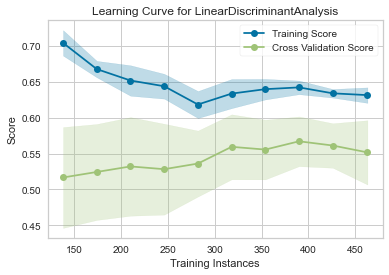

In [74]:
plot_model(lgbm, plot = 'learning')

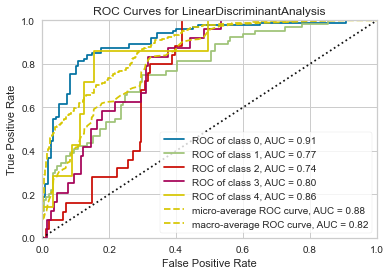

In [76]:
plot_model(lgbm, plot = 'auc')

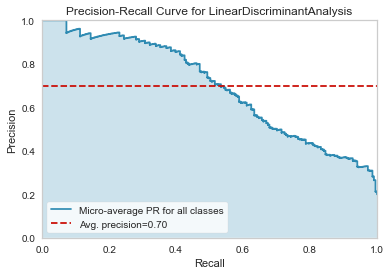

In [77]:
plot_model(lgbm, plot = 'pr')

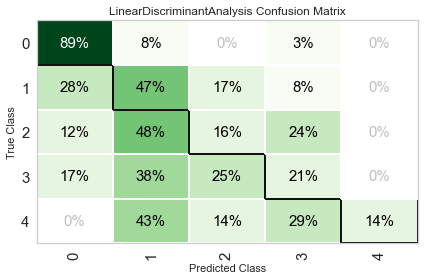

In [78]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

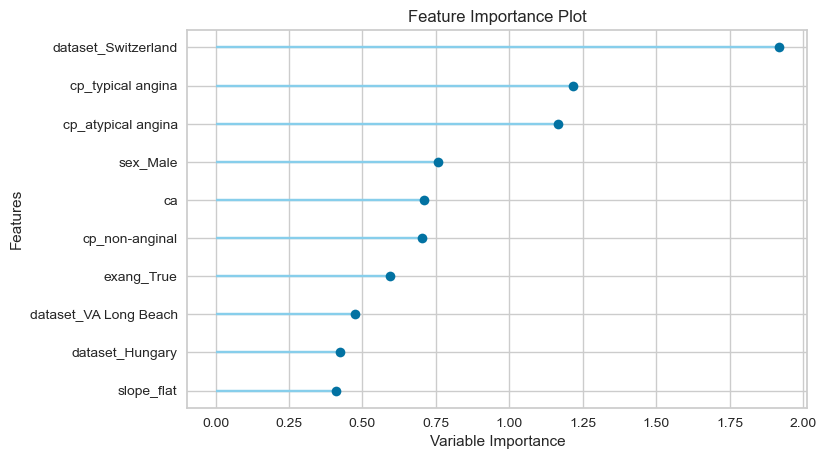

In [79]:
plot_model(lgbm, plot='feature') 

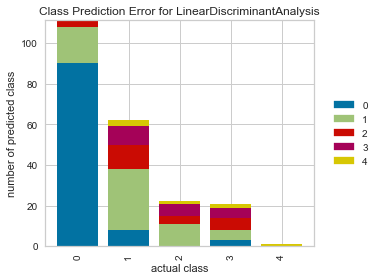

In [80]:
plot_model(lgbm, plot='error')

In [96]:
# !pip install shap
# from shap import LinearExplainer
# !pip install pycaret[analysis]
# interpret model using shap
# interpret_model(lgbm)
# LinearExplainer(lgbm)

In [91]:
predict_model(lgbm, test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5435,0.8292,0.5435,0.5095,0.5202,0.3374,0.3407


,age,trestbps,chol,thalch,oldpeak,ca,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect,num,prediction_label,prediction_score
319,36,120.0,166.0,180.0,0.0,NaN,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0.9581
377,45,140.0,224.0,122.0,0.0,NaN,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0.9360
538,48,160.0,329.0,92.0,1.5,NaN,1,1,0,0,...,1,0,1,1,0,0,0,1,1,0.8945
296,59,164.0,176.0,90.0,1.0,2.0,1,0,0,0,...,0,0,0,1,0,0,0,3,4,0.6636
531,40,150.0,392.0,130.0,2.0,NaN,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0.5888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,46,140.0,275.0,165.0,0.0,NaN,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0.8323
97,60,150.0,258.0,157.0,2.6,2.0,0,0,0,0,...,0,0,0,1,0,0,1,3,4,0.4331
906,61,120.0,337.0,98.0,0.0,NaN,1,0,0,1,...,1,0,1,0,0,0,0,3,1,0.3483
467,55,120.0,270.0,140.0,0.0,NaN,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0.5331
